<h1>Implementassi BLSD Dengan CNN

<hr>
<h1>Data Explor data</h1>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3

In [3]:
dataset1 = tf.keras.preprocessing.image_dataset_from_directory(r'F:\model skripsi\BananaLSD\OriginalSet',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 937 files belonging to 4 classes.


In [4]:
dataset2 = tf.keras.preprocessing.image_dataset_from_directory(r'F:\model skripsi\BananaLSD\AugmentedSet',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1600 files belonging to 4 classes.


In [5]:
dataset = dataset1.concatenate(dataset2)
len(dataset)*32

2560

In [6]:
data_iterator = dataset.as_numpy_iterator()
batch = data_iterator.next()
batch[0].shape

(32, 224, 224, 3)

* 32: memproses 32 gambar dalam satu batch.

* 224, 224: setiap gambar memiliki tinggi dan lebar 224 piksel.

* 3: Angka 3 umumnya menunjukkan gambar berwarna (RGB: Red, Green, Blue).

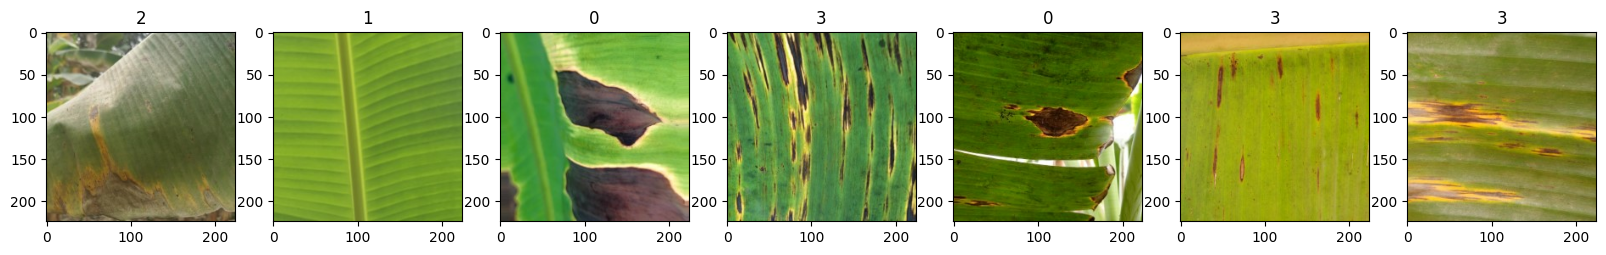

In [7]:
fig, ax = plt.subplots(ncols=7, figsize=(20,20))
for idx, img in enumerate(batch[0][:7]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(str(batch[1][idx]))

<div class="alert alert-block alert-info">
<b>note:</b> 'cordana'= 0, 'healthy'= 1, 'pestalotiopsis'= 2, 'sigatoka'= 3.
</div>

<h1>Pra-pemrosesan Data</h1>

<hr>
<h2> Normalisasi data </h2>

In [8]:
dataset= dataset.map(lambda x,y: (x/255, y))

In [9]:
dataset.as_numpy_iterator().next()

(array([[[[0.5921569 , 0.5568628 , 0.28627452],
          [0.59607846, 0.56078434, 0.2901961 ],
          [0.6       , 0.5686275 , 0.28627452],
          ...,
          [0.42352942, 0.5137255 , 0.16078432],
          [0.42745098, 0.5176471 , 0.17254902],
          [0.4392157 , 0.5294118 , 0.18431373]],
 
         [[0.59607846, 0.56078434, 0.2901961 ],
          [0.59607846, 0.56078434, 0.2901961 ],
          [0.59607846, 0.5647059 , 0.28235295],
          ...,
          [0.42745098, 0.5176471 , 0.16470589],
          [0.42352942, 0.5137255 , 0.16862746],
          [0.42745098, 0.5176471 , 0.17254902]],
 
         [[0.6       , 0.5647059 , 0.29411766],
          [0.59607846, 0.56078434, 0.2901961 ],
          [0.5921569 , 0.56078434, 0.2784314 ],
          ...,
          [0.43137255, 0.50980395, 0.16862746],
          [0.42745098, 0.5058824 , 0.17254902],
          [0.43137255, 0.50980395, 0.1764706 ]],
 
         ...,
 
         [[0.58431375, 0.5372549 , 0.23921569],
          [0.58431

<h2>SPLIT DATA TRAIN VAL TEST</h2>

In [10]:
train_size = int(len(dataset)*.7)
val_size = int(len(dataset)*.2)+1
test_size = int(len(dataset)*.1)+1

In [11]:
train = dataset.take(train_size)
val = dataset.skip(train_size).take(val_size)
test = dataset.skip(train_size+val_size).take(test_size)

In [12]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

<h1>Modeling</h1>
<hr>

<h2>Costom cnn model </h2>

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D

In [14]:
custom_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
custom_model.compile(optimizer = 'adam',loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])

In [16]:
custom_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       294,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 360,776 (1.38 MB)

 Trainable params: 360,776 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
hist = custom_model.fit(train, epochs=15, validation_data=val)

Epoch 1/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.4718 - loss: 1.3100 - val_accuracy: 0.5368 - val_loss: 1.1278
Epoch 2/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.5755 - loss: 1.0022 - val_accuracy: 0.5827 - val_loss: 0.9964
Epoch 3/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 987ms/step - accuracy: 0.6605 - loss: 0.8153 - val_accuracy: 0.6250 - val_loss: 0.8499
Epoch 4/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 996ms/step - accuracy: 0.7335 - loss: 0.6782 - val_accuracy: 0.7555 - val_loss: 0.6371
Epoch 5/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 992ms/step - accuracy: 0.7603 - loss: 0.6180 - val_accuracy: 0.7721 - val_loss: 0.6082
Epoch 6/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8075 - loss: 0.5297 - val_accuracy: 0.8162 - val_loss: 0.5322
Epoch 7/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.8110 - loss: 0.4858 - val_accuracy: 0.7721 - val_loss: 0.5551
Epoch 8/15
56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 990ms/step - accuracy: 0.8323 - loss: 0.4361 - val_accuracy: 0.8235

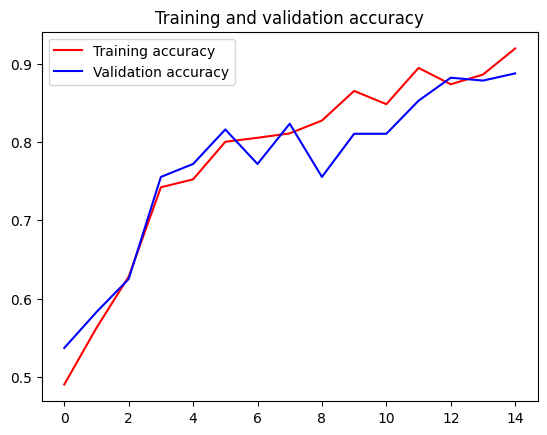

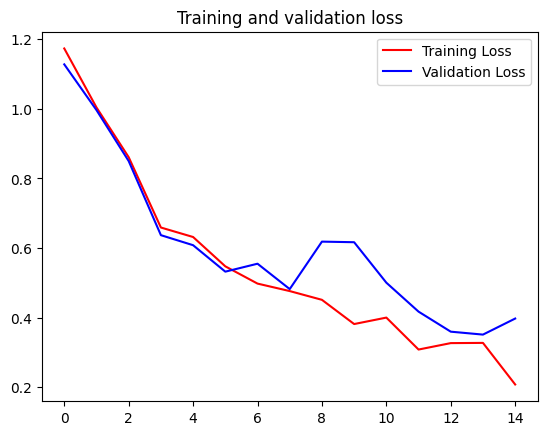

In [18]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<h2>Resnet Model</h2>
<HR>

<div class="alert alert-block alert-danger">
<b>kenapa: Resnet50 gak mau load</b> 
</div>

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

In [23]:
# Create a ResNet50 model with pre-trained weights
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained ResNet50 model
for layer in resnet_model.layers:
    layer.trainable = False


# Create a new model on top of the ResNet50 model
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(GlobalAveragePooling2D())
model_resnet.add(Dense(4, activation='softmax'))

# Build the model
# The model needs to be built before the summary can be displayed
model_resnet.build(input_shape=(None, 256, 256, 3))

# Print the model summary
model_resnet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [24]:
model_resnet.compile(optimizer='adam', loss ='sparse_categorical_crossentropy',metrics = ['accuracy'])

In [27]:
history_resnet = model_resnet.fit(train, epochs=10, validation_data=val)

Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "resnet50" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 224, 224, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • training=True
  • mask=None